## Problem 1 (Lookback Options, 10 points)
 - $\text{Payoff of a float call} = (S_T - \min_{0\leq t\leq T}S_t)$
 - $\text{Payoff of a float put} = ( - S_T)$
 - $\text{Payoff of a fix call} = \max{(\max_{0\leq t\leq T}S_t - K, 0)}$
 - $\text{Payoff of a fix put} = \max{(K - \min_{0\leq t\leq T}S_t, 0)}$

(a) Using a dynamic Monte Carlo approximation for the stock price in the Black-Scholes model. Write a function to approximate the initial price of a **floating strike Lookback put**. The initial arbitrage free price is give by 
$$e^{-rT}\mathbb{E}^*\left[\max_{0\leq t\leq T} S_t - S_T\right], $$ where the option maturity is $T$ years and the stock, under the risk neutral probability, follows the Black-Scholes model, i.e.
$$S_t = S_0\exp{((r-\sigma^2/2)t+\sigma W(t))}, \quad t\in[0, T], $$ where $r$ is the risk-free interest rate and $\{W(t), t\in[0,T]\}$ is a standard Brownian motion. 

In [1]:
# Import the necessary packages here

# YOUR CODE HERE
import pandas as pd
import numpy as np

In the following cells, we would first work on it step by step and then combine the code together and write a function for pricing the floating strike Lookback put option.

In [2]:
# Set parameters and try to work step by step first 
T = 7  # time to maturity
S0 = 20  # initial stock price
r = 0.1  # interest rate
sig = 1  # standard deviation (volatility)
M = 10000  # number of Monte Carlo sample
dt = 0.1  # the increment in discretization

In [3]:
# Compute the number of steps N (=T/dt).
# Simulate all Zi's (Brownian Motion terms) and store them in matrix Zt.
# Simulate M stock price paths with each path has length N: call it matrix St.
# Make sure to assign random seed 111 before you generate the random standard normal samples.

# YOUR CODE HERE
np.random.seed(111)
N = int(T/dt)
Zt = np.random.normal(0,np.sqrt(dt),(M,N))
St = np.zeros((M,N))
St[:,0]= S0*np.exp((r-0.5*sig**2)*dt+sig*Zt[:,0])
for n in range(1,N):
    St[:,n]= St[:,n-1]*np.exp((r-0.5*sig**2)*dt+sig*Zt[:,n])
St[0,0]

13.425838681599666

In [4]:
# YOUR CODE HERE
LookbackPut = np.zeros((M))
for m in range(M):
    LookbackPut[m] = np.max(St[m,:])-St[m,-1]

In [5]:
"""Check the stock price paths simulation (dimension)"""
assert St.shape == (M, N)

In [6]:
"""Check the stock price paths simulation (values)"""
assert round(St[0,0], 2) == 13.43

In [7]:
"""Check the computation of payoff and arbitrage free initial price"""
assert len(LookbackPut) == 10000
assert round(LookbackPut[0], 2) == 22.01

In [8]:
# Combine the code you wrote before to a function (call it LookbackPut_float)
def LookbackPut_float(T, S0, r, sig, dt, M, seed):
    """
    input: 
        T: time to maturity
        S0: initial stock price
        r: interest rate
        sig: volatility
        dt: the increment in discretization
        M: number of Monte Carlo sample paths
        seed: random seed for numpy random normal generator 
    -------------------------------------------------------
    output:
        estimated arbitrage free initial price
    """
    # YOUR CODE HERE
    np.random.seed(seed)
    
    N = int(T/dt)
    Zt = np.random.normal(0,np.sqrt(dt),(M,N))
    
    St = np.zeros((M,N))
    St[:,0]= S0*np.exp((r-0.5*sig**2)*dt+sig*Zt[:,0])
    for n in range(1,N):
        St[:,n]= St[:,n-1]*np.exp((r-0.5*sig**2)*dt+sig*Zt[:,n])
        
    LookbackPut = np.zeros((M))
    for m in range(M):
        LookbackPut[m] = np.max(St[m,:])-St[m,-1]
        
    price = np.mean(LookbackPut)*np.exp(-r*T)
    
    return price

LookbackPut_float(7, 20, 0.1, 0.2, 0.01, 1000, 111)

3.5556792801499504

In [9]:
"""Check your function: LookbackPut_float; do not change the code in this cell"""
p_test = LookbackPut_float(7, 20, 0.1, 0.2, 0.01, 1000, 111)
assert round(p_test, 2) == 3.56

(b) Use the function to price a floating strike Lookback put with $S_0=40, r=0.1, \sigma=0.2, T=10$.
Try to run for $dt = 0.1$ and $dt = 0.01$ respectively. 

In [10]:
seed = 123
M = 10000
# let dt = 0.1 first; run your function using the specified parameters
# let the output be p1
# YOUR CODE HERE
S0 = 40
r=0.1
sig=0.2
T=10
dt=0.1
p1 =  LookbackPut_float(T, S0, r, sig, dt, M, seed)

In [11]:
"""Check your answer for p1"""
assert round(p1, 2) == 6.17

In [12]:
# Let dt = 0.01 and compute p2.
seed = 123
M = 10000
# YOUR CODE HERE
S0 = 40
r=0.1
sig=0.2
T=10
dt = 0.01
p2 =  LookbackPut_float(T, S0, r, sig, dt, M, seed)

In [13]:
"""Check your answer for p2"""
assert round(p2, 2) == 7.28

## Problem 2 (Discrete time Asian Options, 10 points)
- Payoff at $T$: $$\max{\left\{K-\frac{1}{T}\int_0^T S_t dt, 0\right\}}.$$
- The initial arbitrage free price for the option is $$e^{-rT}E^*\left[\max\left(K-\frac{1}{T}\int_0^T S_t ds, 0\right)\right].$$

(a) Write a function for pricing an Asian put option.

In [14]:
def AsianPut_Pricing(T, S0, K, r, sig, dt, M, seed):
    """
    input:
        T: time to maturity
        S0: initial stock price
        K: strike price
        r: interest rate
        sig: volatility
        dt: the increment in discretization
        M: number of sample paths
        seed: random seed of numpy random generater
    output:
        AsP: estimated arbitrage free initial price for Asian put option 
    """
    # YOUR CODE HERE
    np.random.seed(seed)
    
    N = int(T/dt)
    Zt = np.random.normal(0,np.sqrt(dt),(M,N))
    
    St = np.zeros((M,N))
    St[:,0]= S0*np.exp((r-0.5*sig**2)*dt+sig*Zt[:,0])
    for n in range(1,N):
        St[:,n]= St[:,n-1]*np.exp((r-0.5*sig**2)*dt+sig*Zt[:,n])
        
    AsianPut = np.zeros((M))
    for m in range(M):
        AsianPut[m] = np.maximum(K-np.mean(St[m,:]),0)
        
    price = np.mean(AsianPut)*np.exp(-r*T)
    
    return price
    
    

In [15]:
"""Check your AsianPut_Pricing function"""
assert round(AsianPut_Pricing(5, 20, 18, 0.1, 0.2, 0.01, 10000, 123), 2) == 0.13

(b) For the same parameters as in part (b) of Exercise 1, find the arbitrage free initial price for the Asian put option described in 2(a) with strike price K = 29.

In [16]:
# YOUR CODE HERE
K = 29

In [17]:
"""Check your answer"""
assert round(AsianPut_Pricing(10, 40, K, 0.1, 0.2, 0.01, 10000, 123), 2) == 0.02

## Problem 3 (the CEV model, 10 points)
The risky asset evolves according to the following stochastic differential equation:
$$dS_t = rS_tdt+\sigma S_t^\gamma dW_t,$$ where $\sigma>0, \gamma>0$.

(a) For $\gamma>1$, write a function to use an Euler approximation to approximate the sample paths of $S_t$ under the CEV model. Draw some sample plots for $T=5, \gamma=1.4, r=0.1, S_0=20, \sigma=0.1$.

Let's do it step by step first and then combine the steps to form a function. 

In [18]:
# Assume the number of steps: N = 10000
N = 10000
T = 5
gamma = 1.4
r = 0.1
S0 = 20
sigma = 0.1
step = T / N

In [19]:
# generate N standard normal samples in a vector Z using random seed 3; 
np.random.seed(3)
# YOUR CODE HERE
Z= np.random.randn(N)

In [20]:
# generate a path (a list of stock prices along time) 
# using the SDE formula and the sampled vector Z, call the list "path"
path, S = [], S0
path.append(S0)

# Write a for loop below to recursively append the list: path to record the sequence of stock prices
# YOUR CODE HERE
for j in range(N):
    St = path[-1] + r*path[-1]*step + sigma*(path[-1]**gamma)*Z[j]*np.sqrt(step)
    path.append(St)


In [21]:
assert round(path[1],1) == 20.3
assert len(path) == N+1

In [22]:
# Write a function to simulate the solution using Euler method by combing the code above
# note in the function, you may need to define variable step and calculate it out
def CEV_euler(T, N, gamma, r, S0, sigma, seed):
    """
    input:
        T: end time
        N: number of small time steps
        gamma, r, S0, sigma: parameters in the CEV model
        seed: random seed to generate the standard normal sequence
    output:
        one sample path (simulation) of the solution of the CEV model using Euler scheme
    """
    # YOUR CODE HERE
    np.random.seed(seed)
    step = T / N
    Z= np.random.randn(N)
    path, S = [], S0
    path.append(S0)
    
    for j in range(N):
        St = path[-1] + r*path[-1]*step + sigma*(path[-1]**gamma)*Z[j]*np.sqrt(step)
        path.append(St)
    
    return path 

In [23]:
"""Check your function"""
assert round(CEV_euler(5, 1000, 0.2, 0.1, 20, 0.1, 9)[-1], 2) == 33.55

In [24]:
# import packages for drawing graph
import matplotlib.pyplot as plt
%matplotlib inline

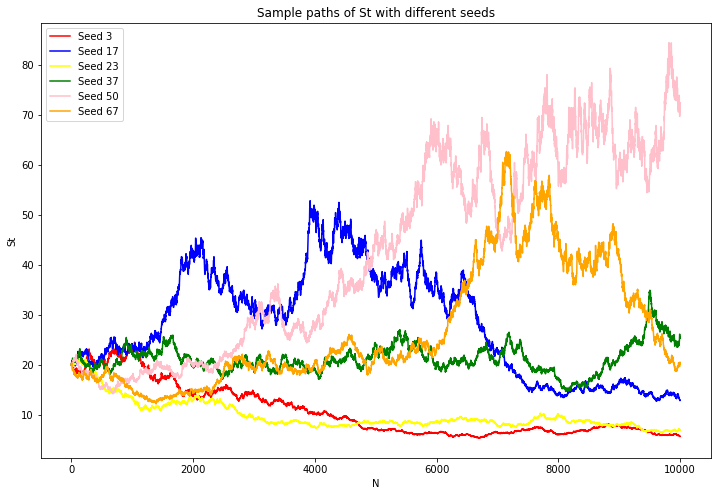

In [25]:
# Draw some sample paths for the specified parameters with different seeds(3, 17, 23, 37, 50, 67)
# color the sample paths differently
# try to add a title of your plot

plt.figure(figsize=(12,8))
# YOUR CODE HERE
N = 10000
T = 5
gamma = 1.4
r = 0.1
S0 = 20
sigma = 0.1

seeds = [3, 17, 23, 37, 50, 67]
colors = ['red','blue','yellow','green','pink','orange']

times = np.arange(N+1)

for i in range(len(seeds)):
    seed = seeds[i]
    colori = colors[i]
    path = CEV_euler(T, N, gamma, r, S0, sigma, seed)
    plt.plot(times,path, label = 'Seed '+str(seed), color = colori)
    
plt.ylabel('St')
plt.xlabel('N')
plt.title('Sample paths of St with different seeds')
plt.legend()
plt.show()

(b) Add to the code developed in 3(a) to approximate the value of 
$$E^*[(\max_{0\leq t\leq T}S_t - K)^+]$$ for the CEV model. Illustrate for the parameters in (a) and for $K=18$. 

In [26]:
# write a function to approximate the required value
# Instead of applying CEV_euler function, we extend the function here by applying the vector operation.
# (extend the Z vector to matrix Z with M rows and do the same operations for all rows at once)
def MC_price(T, N, gamma, r, S0, sigma, seed, M, K):
    """
    input:
        T: end time
        N: number of small time steps
        gamma, r, S0, sigma: parameters in the CEV model
        seed: random seed to generate the standard normal sequence
        K: strike price
    output:
        the estimation on the E*[maxSt - K, 0]
    """
    step = T / N
    np.random.seed(seed)
    Z = np.random.normal(0, 1, size=(M, N))
    # YOUR CODE HERE
    path=np.zeros((M,N+1))
    path[:,0]=S0
    for j in range(1,N+1):
        path[:,j] = path[:,j-1] + r*path[:,j-1]*step + sigma*(path[:,j-1]**gamma)*Z[:,j-1]*np.sqrt(step)
    
    payoff = np.zeros((M))
    for m in range(M):
        payoff[m] = np.maximum(np.max(path[m,:])-K,0)
        
    return np.mean(payoff)

MC_price(T, N, gamma, r, S0, sigma, 3, 1000, 18)

46.33017513358878

In [27]:
"""Check your function """
assert round(MC_price(T, N, gamma, r, S0, sigma, 3, 1000, 18), 2) == 46.33